In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import json
from datetime import datetime
from tqdm import tqdm

In [3]:
os.getcwd()

'e:\\code\\eye_disease\\project\\notebooks'

In [4]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import label_binarize

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 10
INITIAL_LR = 1e-4
PATIENCE = 10

In [8]:
# Paths for Google Colab
DATA_PATH = "../data/Augmented_images"
MODEL_SAVE_PATH = "../models/eye_disease"
LOGS_PATH = "/logs/eye_disease"
RESULTS_PATH = "../results/eye_disease"

In [9]:
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [10]:
print(f"✅ Directories created:")
print(f"   - Data: {DATA_PATH}")
print(f"   - Models: {MODEL_SAVE_PATH}")
print(f"   - Logs: {LOGS_PATH}")
print(f"   - Results: {RESULTS_PATH}")

✅ Directories created:
   - Data: ../data/Augmented_images
   - Models: ../models/eye_disease
   - Logs: /logs/eye_disease
   - Results: ../results/eye_disease


In [11]:
# Class names (must match folder names exactly)
CLASS_NAMES = [
    'Central_Serous_Chorioretinopathy',
    'Diabetic_Retinopathy',
    'Disc_Edema',
    'Glaucoma',
    'Healthy',
    'Macular_Scar',
    'Myopia',
    'Pterygium',
    'Retinal_Detachment',
    'Retinitis_Pigmentosa'
]

In [12]:
print(f"✅ {len(CLASS_NAMES)} classes defined")

✅ 10 classes defined


In [13]:
# Check if data path exists
if not os.path.exists(DATA_PATH):
    print(f"❌ ERROR: Data path not found: {DATA_PATH}")
    print("Please upload your data to Google Drive in the correct structure:")
    print(f"   {DATA_PATH}/")
    print("   ├── Central Serous Chorioretinopathy/")
    print("   ├── Diabetic Retinopathy/")
    print("   └── ...")
else:
    print(f"✅ Data path found: {DATA_PATH}")

✅ Data path found: ../data/Augmented_images


In [14]:
# Count images in each class
class_counts = {}
class_info = []

In [15]:
for class_name in CLASS_NAMES:
    class_path = os.path.join(DATA_PATH, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        class_counts[class_name] = len(images)
        
        if images:
            # Check sample image properties
            sample_img = os.path.join(class_path, images[0])
            try:
                img = Image.open(sample_img)
                class_info.append({
                    'class': class_name,
                    'count': len(images),
                    'width': img.size[0],
                    'height': img.size[1],
                    'mode': img.mode
                })
            except:
                pass
    else:
        print(f"⚠️ Warning: Class folder not found: {class_name}")
        class_counts[class_name] = 0

In [16]:
# Display class distribution
print("\n📊 Class Distribution:")
for class_name, count in class_counts.items():
    print(f"   {class_name}: {count} images")


📊 Class Distribution:
   Central_Serous_Chorioretinopathy: 606 images
   Diabetic_Retinopathy: 3444 images
   Disc_Edema: 762 images
   Glaucoma: 2880 images
   Healthy: 2676 images
   Macular_Scar: 1937 images
   Myopia: 2251 images
   Pterygium: 102 images
   Retinal_Detachment: 750 images
   Retinitis_Pigmentosa: 834 images


In [17]:
total_images = sum(class_counts.values())
print(f"\n📈 Total images: {total_images}")


📈 Total images: 16242


Text(0, 0.5, 'Eye Diseases')

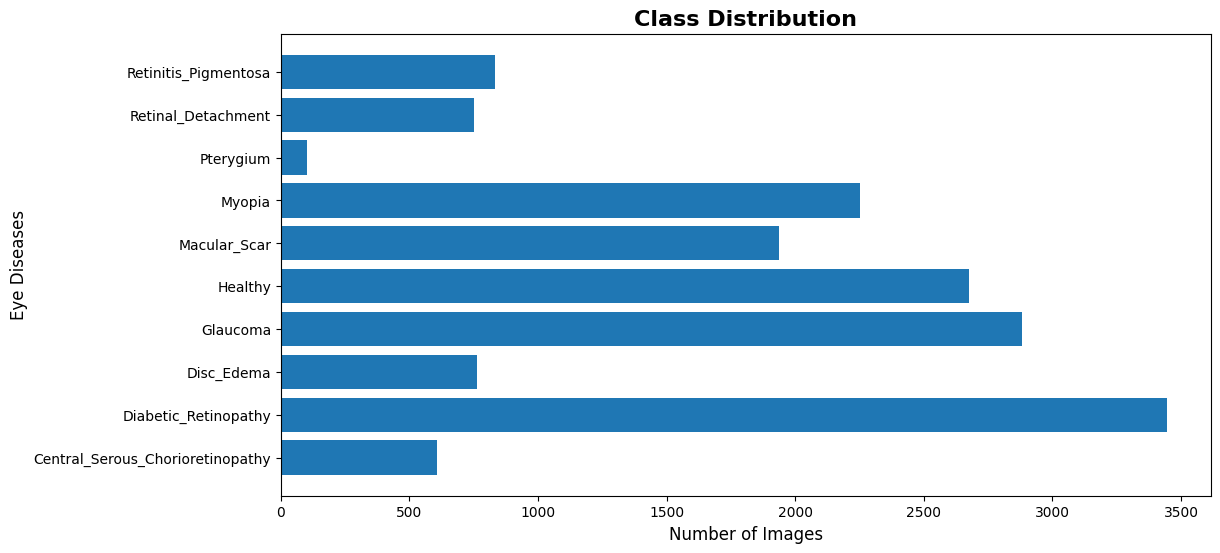

In [18]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
bars = plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Eye Diseases', fontsize=12)

In [19]:
# Add value labels
for bar in bars:
    width = bar.get_width()
    x_pos = width + max(class_counts.values()) * 0.01
    plt.text(x_pos, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center')
plt.tight_layout()
# Save with memory-safe fallbacks and free memory
import gc
gc.collect()
save_path = os.path.join(RESULTS_PATH, 'class_distribution.png')
# Try high quality first, fall back on MemoryError
saved = False
for dpi in (150, 100, 80,50):
    try:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f'Saved class distribution at {dpi} DPI ->', save_path)
        saved = True
        break
    except MemoryError:
        print(f'MemoryError saving at {dpi} DPI, trying lower DPI...')
        gc.collect()
if not saved:
    # As a last resort, save a small thumbnail to avoid failure
    try:
        thumb_path = os.path.join(RESULTS_PATH, 'class_distribution_thumb.png')
        plt.savefig(thumb_path, dpi=72, bbox_inches='tight')
        print('Saved thumbnail as fallback ->', thumb_path)
    except Exception as e:
        print('Failed to save figure after multiple attempts:', e)
# Attempt to display; if too large, skip display to avoid notebook crash
try:
    plt.show()
except MemoryError:
    print('Plot saved to disk, but too large to display in notebook.')
# Close figure to release memory
plt.close()

MemoryError saving at 150 DPI, trying lower DPI...
MemoryError saving at 100 DPI, trying lower DPI...
Saved class distribution at 80 DPI -> ../results/eye_disease\class_distribution.png


MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>


🖼️ Displaying sample images from each class...


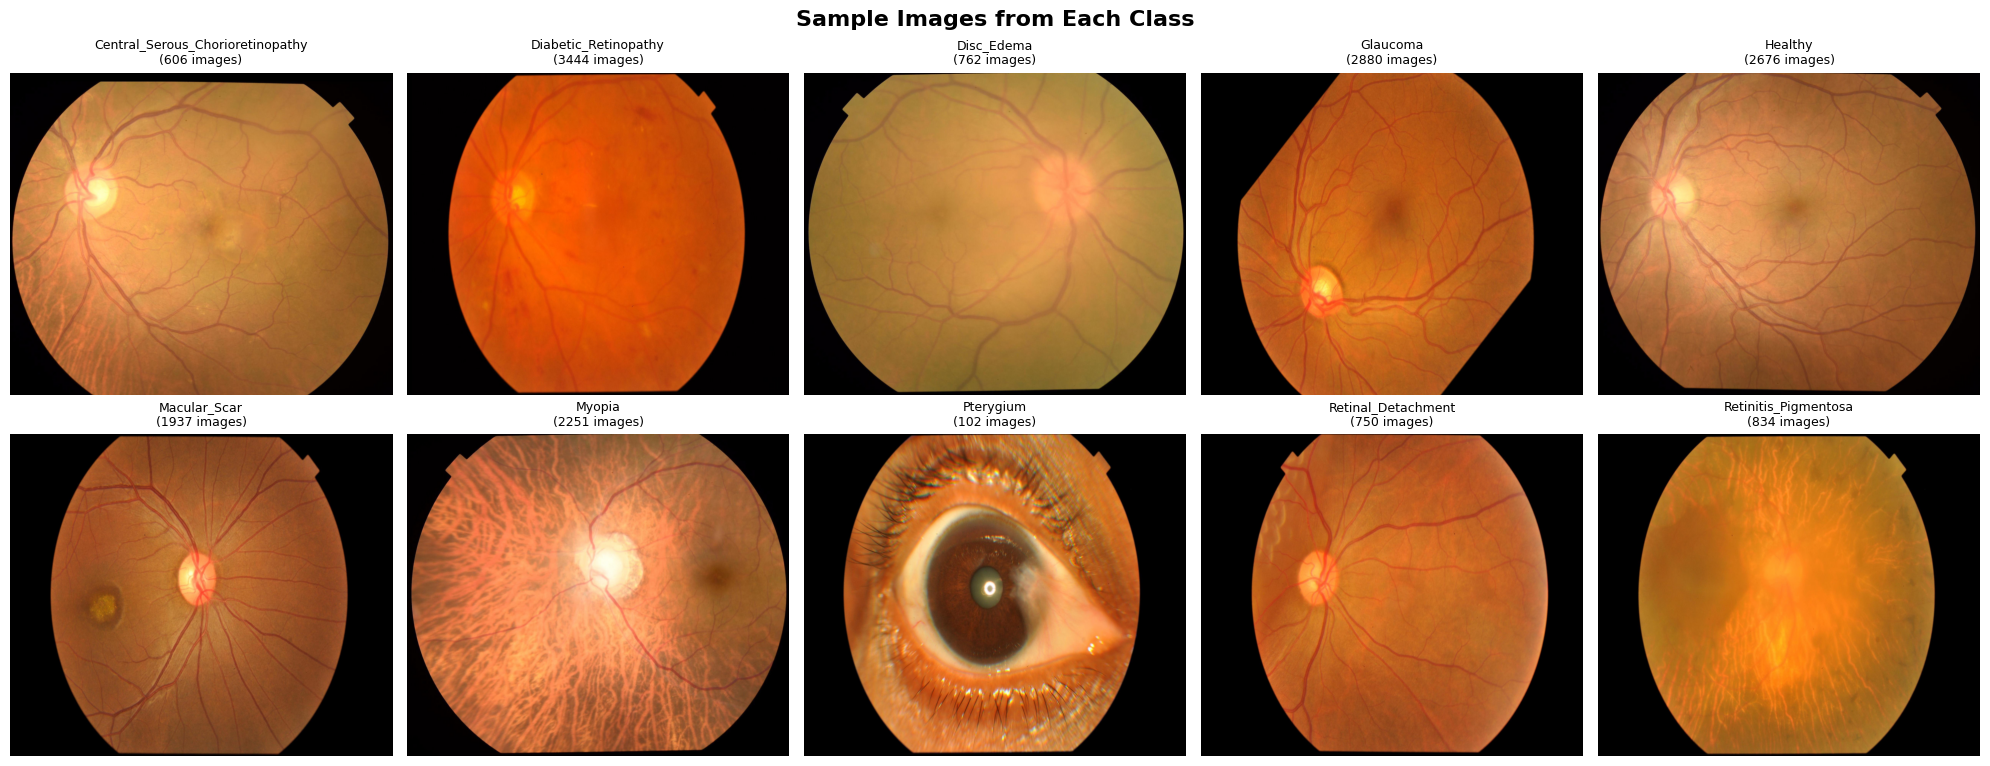

In [20]:
# Display sample images
print("\n🖼️ Displaying sample images from each class...")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
for idx, class_name in enumerate(CLASS_NAMES):
    row = idx // 5
    col = idx % 5
    class_path = os.path.join(DATA_PATH, class_name)
    
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_path = os.path.join(class_path, random.choice(images))
            try:
                img = Image.open(img_path)
                axes[row, col].imshow(img)
                axes[row, col].set_title(f'{class_name}\n({class_counts[class_name]} images)', fontsize=9)
                axes[row, col].axis('off')
            except:
                axes[row, col].text(0.5, 0.5, 'Error\nloading', ha='center', va='center')
                axes[row, col].axis('off')
        else:
            axes[row, col].text(0.5, 0.5, 'No\nimages', ha='center', va='center')
            axes[row, col].axis('off')
    else:
        axes[row, col].text(0.5, 0.5, 'Folder\nnot found', ha='center', va='center')
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'sample_images.png'), dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print("📊 Setting up data generators...")

# Medical-specific augmentations for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Important for retinal symmetry
    brightness_range=[0.8, 1.2],
    fill_mode='reflect',
    validation_split=0.2  # 20% for validation
)

📊 Setting up data generators...


In [22]:
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [23]:
# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

Found 12997 images belonging to 10 classes.


In [24]:
# Create validation generator
val_generator = val_test_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

Found 3245 images belonging to 10 classes.


In [25]:
print(f"✅ Data generators created:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Classes: {list(train_generator.class_indices.keys())}")


✅ Data generators created:
   Training samples: 12997
   Validation samples: 3245
   Classes: ['Central_Serous_Chorioretinopathy', 'Diabetic_Retinopathy', 'Disc_Edema', 'Glaucoma', 'Healthy', 'Macular_Scar', 'Myopia', 'Pterygium', 'Retinal_Detachment', 'Retinitis_Pigmentosa']


In [26]:
# Display batch of augmented images
print("\n🎨 Visualizing augmented images...")


🎨 Visualizing augmented images...


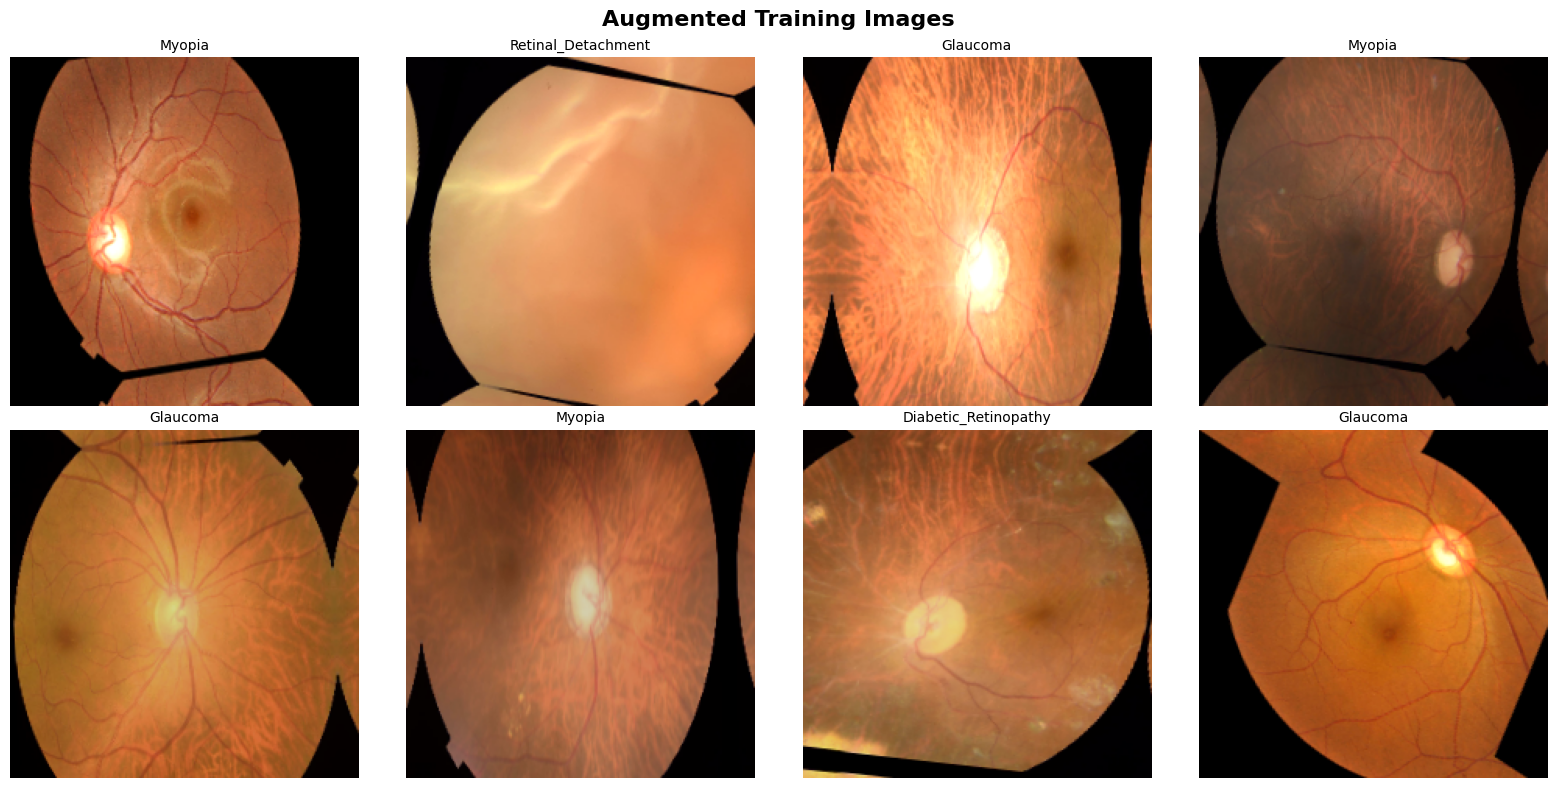

In [27]:
# Get a batch
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(8):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    class_name = CLASS_NAMES[class_idx]
    axes[row, col].set_title(f'{class_name}', fontsize=10)
    axes[row, col].axis('off')

plt.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'augmented_images.png'), dpi=300, bbox_inches='tight')
plt.show()

In [28]:
print("🧠 Setting up medical-specific loss functions and metrics...")

🧠 Setting up medical-specific loss functions and metrics...


In [29]:
# Focal Loss for handling class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        
        # Calculate cross entropy
        cross_entropy = -y_true * keras.backend.log(y_pred)
        
        # Calculate weight
        weight = alpha * y_true * keras.backend.pow((1 - y_pred), gamma)
        
        # Focal loss
        loss = weight * cross_entropy
        
        # Sum over classes
        loss = keras.backend.sum(loss, axis=1)
        return loss
    return focal_loss_fixed

In [30]:
def specificity(y_true, y_pred):
    """Specificity (True Negative Rate)"""
    true_negatives = keras.backend.sum(
        keras.backend.round(keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1))
    )
    possible_negatives = keras.backend.sum(
        keras.backend.round(keras.backend.clip(1 - y_true, 0, 1))
    )
    return true_negatives / (possible_negatives + keras.backend.epsilon())

In [31]:
def sensitivity(y_true, y_pred):
    """Sensitivity (Recall)"""
    true_positives = keras.backend.sum(
        keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1))
    )
    possible_positives = keras.backend.sum(
        keras.backend.round(keras.backend.clip(y_true, 0, 1))
    )
    return true_positives / (possible_positives + keras.backend.epsilon())


In [32]:
print("✅ Medical loss functions and metrics defined")

✅ Medical loss functions and metrics defined


In [33]:
print("🏗️ Building Medical-Optimized EfficientNet CNN...")

🏗️ Building Medical-Optimized EfficientNet CNN...


In [34]:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

In [35]:
# 🔬 Medical fine-tuning strategy
for layer in base_model.layers[:-40]:
    layer.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True

In [36]:
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = keras.applications.efficientnet.preprocess_input(inputs)

In [37]:
x = base_model(x, training=True)

In [38]:
# 🧠 Feature refinement (medical-safe)
x = layers.Conv2D(256, 1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)


In [39]:
# 🌍 Global context (important for retinal structure)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

In [40]:
# 🩺 Classification head (balanced for sensitivity)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

In [41]:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

In [42]:
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

In [43]:
cnn_model = keras.Model(inputs, outputs, name="Medical_EfficientNet_CNN")

In [44]:
loss = keras.losses.CategoricalCrossentropy(
    label_smoothing=0.1
)

In [45]:
metrics = [
    keras.metrics.CategoricalAccuracy(name="accuracy"),
    keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_accuracy"),
    keras.metrics.AUC(
        name="auc",
        multi_label=True,
        num_labels=NUM_CLASSES
    )
]


In [46]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    loss=loss,
    metrics=metrics
)

In [47]:
cnn_model.summary()

Model: "Medical_EfficientNet_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,479,533 (17.09 MB)

 Trainable params: 2,479,642 (9.46 MB)

 Non-trainable params: 1,999,891 (7.63 MB)

In [49]:
# Compute class weights for imbalanced data
total_samples = train_generator.samples
class_weights = {}

for class_idx in range(NUM_CLASSES):
    class_count = np.sum(train_generator.classes == class_idx)
    if class_count > 0:
        class_weights[class_idx] = total_samples / (NUM_CLASSES * class_count)
    else:
        class_weights[class_idx] = 1.0

print("⚖️ Class weights for imbalance handling:")
for class_idx, weight in class_weights.items():
    print(f"   {CLASS_NAMES[class_idx]}: {weight:.2f}")

⚖️ Class weights for imbalance handling:
   Central_Serous_Chorioretinopathy: 2.68
   Diabetic_Retinopathy: 0.47
   Disc_Edema: 2.13
   Glaucoma: 0.56
   Healthy: 0.61
   Macular_Scar: 0.84
   Myopia: 0.72
   Pterygium: 15.85
   Retinal_Detachment: 2.17
   Retinitis_Pigmentosa: 1.95


In [51]:
# Define callbacks for EfficientNet (Medical CNN)

efficientnet_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),

    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, 'efficientnet_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    callbacks.TensorBoard(
        log_dir=os.path.join(LOGS_PATH, 'efficientnet'),
        histogram_freq=1
    ),

    callbacks.CSVLogger(
        os.path.join(LOGS_PATH, 'efficientnet_history.csv')
    )
]

print("✅ EfficientNet callbacks initialized")


✅ EfficientNet callbacks initialized


In [52]:
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,   # ✔ correct for medical imbalance
    callbacks=efficientnet_callbacks,
    verbose=1
)


Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1099 - auc: 0.5041 - loss: 2.5984 - top2_accuracy: 0.2109
Epoch 1: val_accuracy improved from None to 0.00616, saving model to ../models/eye_disease\efficientnet_best.h5



Epoch 1: finished saving model to ../models/eye_disease\efficientnet_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 1022s 2s/step - accuracy: 0.1048 - auc: 0.5023 - loss: 2.4940 - top2_accuracy: 0.2043 - val_accuracy: 0.0062 - val_auc: 0.5008 - val_loss: 2.3280 - val_top2_accuracy: 0.0524 - learning_rate: 2.0000e-04
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0912 - auc: 0.5065 - loss: 2.3717 - top2_accuracy: 0.1900
Epoch 2: val_accuracy improved from 0.00616 to 0.04622, saving model to ../models/eye_disease\efficientnet_best.h5



Epoch 2: finished saving model to ../models/eye_disease\efficientnet_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.0955 - auc: 0.5051 - loss: 2.3570 - top2_accuracy: 0.1979 - val_accuracy: 0.0462 - val_auc: 0.5000 - val_loss: 2.3119 - val_top2_accuracy: 0.2237 - learning_rate: 2.0000e-04
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0953 - auc: 0.4925 - loss: 2.3413 - top2_accuracy: 0.1903
Epoch 3: val_accuracy improved from 0.04622 to 0.11926, saving model to ../models/eye_disease\efficientnet_best.h5



Epoch 3: finished saving model to ../models/eye_disease\efficientnet_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 766s 2s/step - accuracy: 0.0946 - auc: 0.4904 - loss: 2.3432 - top2_accuracy: 0.1937 - val_accuracy: 0.1193 - val_auc: 0.5025 - val_loss: 2.2964 - val_top2_accuracy: 0.3205 - learning_rate: 2.0000e-04
Epoch 4/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0921 - auc: 0.4982 - loss: 2.3436 - top2_accuracy: 0.1953
Epoch 4: val_accuracy did not improve from 0.11926
407/407 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.0981 - auc: 0.4940 - loss: 2.3359 - top2_accuracy: 0.2025 - val_accuracy: 0.0468 - val_auc: 0.5000 - val_loss: 2.2984 - val_top2_accuracy: 0.1661 - learning_rate: 2.0000e-04
Epoch 5/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0841 - auc: 0.4952 - loss: 2.3141 - top2_accuracy: 0.1827
Epoch 5: val_accuracy did not improve from 0.11926
407/407 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.0752 - auc: 0.4935 - loss: 2.3183 - top2_accuracy: 0.1689 

KeyboardInterrupt: 

In [53]:
# =========================
# PHASE 1: WARM-UP TRAINING
# =========================

print("🔒 Freezing EfficientNet base model for warm-up...")

for layer in cnn_model.layers:
    if "efficientnet" in layer.name.lower():
        layer.trainable = False

cnn_model.summary()


🔒 Freezing EfficientNet base model for warm-up...


Model: "Medical_EfficientNet_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,438,819 (36.01 MB)

 Trainable params: 428,938 (1.64 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

 Optimizer params: 4,959,286 (18.92 MB)

In [54]:
# Compile for warm-up phase

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=metrics
)

print("✅ Model compiled for warm-up phase")

✅ Model compiled for warm-up phase


In [55]:
# Warm-up training (NO class weights)

history_warmup = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    callbacks=efficientnet_callbacks,
    verbose=1
)


Epoch 1/7
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1661 - auc: 0.4923 - loss: 2.2080 - top2_accuracy: 0.3302
Epoch 1: val_accuracy improved from 0.11926 to 0.21202, saving model to ../models/eye_disease\efficientnet_best.h5



Epoch 1: finished saving model to ../models/eye_disease\efficientnet_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.1855 - auc: 0.4974 - loss: 2.1736 - top2_accuracy: 0.3553 - val_accuracy: 0.2120 - val_auc: 0.5000 - val_loss: 2.1098 - val_top2_accuracy: 0.3769 - learning_rate: 0.0010
Epoch 2/7
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1996 - auc: 0.4983 - loss: 2.1502 - top2_accuracy: 0.3785
Epoch 2: val_accuracy did not improve from 0.21202
407/407 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.2024 - auc: 0.5019 - loss: 2.1377 - top2_accuracy: 0.3808 - val_accuracy: 0.2120 - val_auc: 0.5000 - val_loss: 2.1118 - val_top2_accuracy: 0.3769 - learning_rate: 0.0010
Epoch 3/7
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2150 - auc: 0.4924 - loss: 2.1242 - top2_accuracy: 0.3999
Epoch 3: val_accuracy did not improve from 0.21202
407/407 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.2090 - auc: 0.4934 - loss: 2.1290 - top2_accuracy: 0.3862 - val_accu

In [56]:
# =========================
# PHASE 2: MEDICAL FINE-TUNING
# =========================

print("🔓 Unfreezing top EfficientNet layers for fine-tuning...")

base_model = cnn_model.get_layer(index=1)  # EfficientNet is layer 1

for layer in base_model.layers[:-30]:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

cnn_model.summary()

🔓 Unfreezing top EfficientNet layers for fine-tuning...


Model: "Medical_EfficientNet_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,337,411 (20.36 MB)

 Trainable params: 1,925,098 (7.34 MB)

 Non-trainable params: 2,554,435 (9.74 MB)

 Optimizer params: 857,878 (3.27 MB)

In [57]:
# Smooth class weights (medical stability)

class_weights_smoothed = {
    k: min(v, 3.0) for k, v in class_weights.items()
}

print("⚖️ Smoothed class weights:")
class_weights_smoothed

⚖️ Smoothed class weights:


{0: np.float64(2.6797938144329896),
 1: np.float64(0.471589259796807),
 2: np.float64(2.130655737704918),
 3: np.float64(0.5641059027777777),
 4: np.float64(0.6070527790751985),
 5: np.float64(0.838516129032258),
 6: np.float64(0.7216546363131594),
 7: 3.0,
 8: np.float64(2.166166666666667),
 9: np.float64(1.9456586826347306)}

In [58]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=metrics
)
print("✅ Model recompiled for fine-tuning")


✅ Model recompiled for fine-tuning


In [59]:
import numpy as np

print("Class distribution:")
print(np.bincount(train_generator.classes))

Class distribution:
[ 485 2756  610 2304 2141 1550 1801   82  600  668]


In [60]:
history_finetune = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights_smoothed,
    callbacks=efficientnet_callbacks,
    verbose=1
)

Epoch 1/25
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2134 - auc: 0.4968 - loss: 2.1569 - top2_accuracy: 0.3814
Epoch 1: val_accuracy did not improve from 0.21202
407/407 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.2122 - auc: 0.4967 - loss: 2.1358 - top2_accuracy: 0.3833 - val_accuracy: 0.2120 - val_auc: 0.5000 - val_loss: 2.1606 - val_top2_accuracy: 0.3895 - learning_rate: 1.0000e-04
Epoch 2/25
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2178 - auc: 0.5006 - loss: 2.1288 - top2_accuracy: 0.3907
Epoch 2: val_accuracy did not improve from 0.21202
407/407 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.2120 - auc: 0.5023 - loss: 2.1150 - top2_accuracy: 0.3892 - val_accuracy: 0.2120 - val_auc: 0.5000 - val_loss: 2.1648 - val_top2_accuracy: 0.3895 - learning_rate: 1.0000e-04
Epoch 3/25
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2134 - auc: 0.4996 - loss: 2.0970 - top2_accuracy: 0.3925
Epoch 3: val_accuracy did not improve from 0.21202
407/407 ━━━━━━━━━━

KeyboardInterrupt: 

In [61]:
cnn_model.save(os.path.join(MODEL_SAVE_PATH, 'efficientnet_final.h5'))
cnn_model.save(os.path.join(MODEL_SAVE_PATH, 'cnn_model.h5'))
cnn_model.save(os.path.join(MODEL_SAVE_PATH, 'cnn_model.keras'))
print("✅ EfficientNet training completed and model saved")

✅ EfficientNet training completed and model saved


In [62]:
# Plot training history
print("\n📈 Plotting training history...")


📈 Plotting training history...


AttributeError: 'Functional' object has no attribute 'history_finetune'

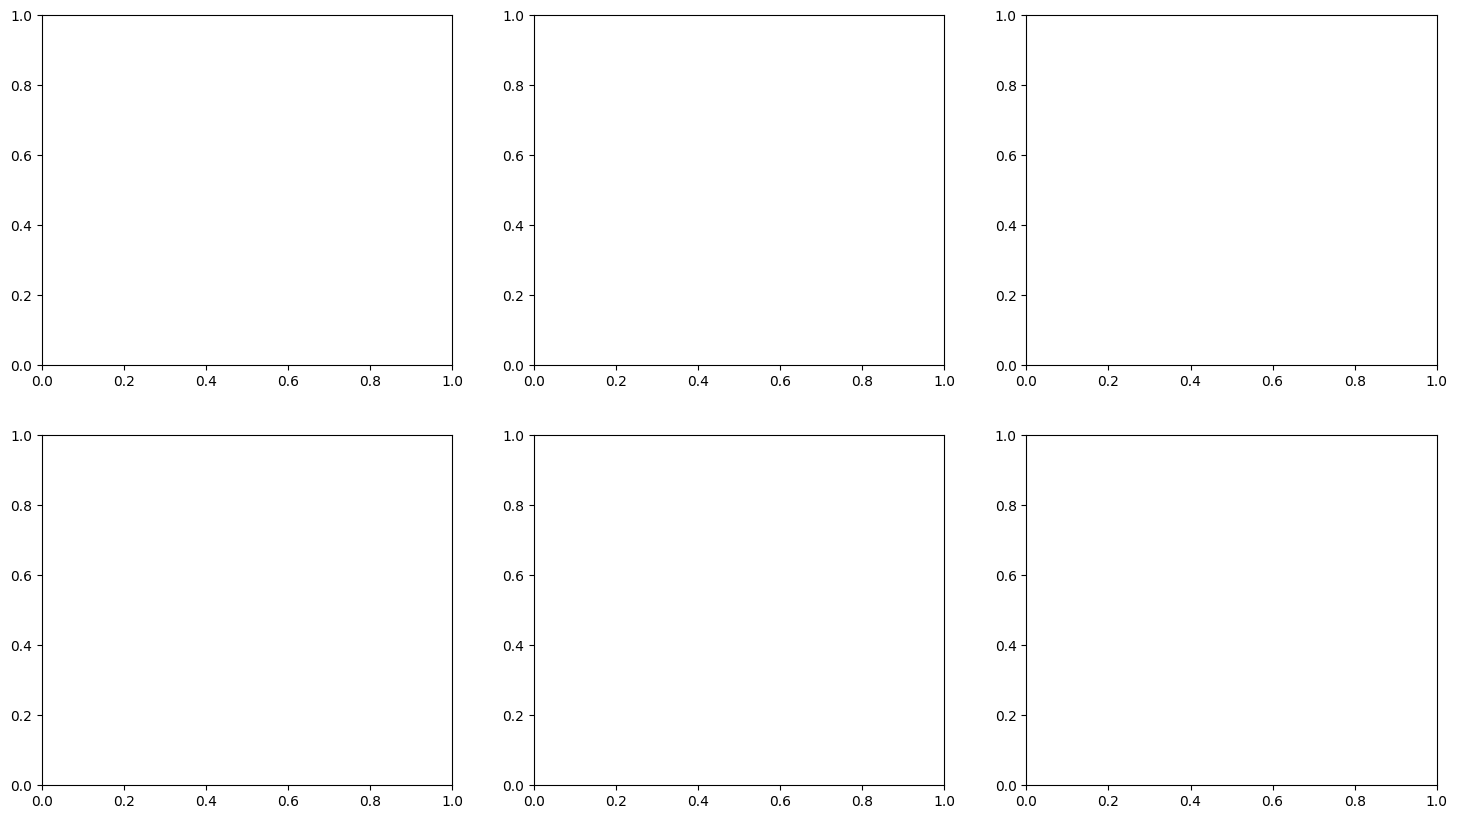

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].plot(cnn_model.history_finetune['accuracy'])
axes[0, 0].plot(cnn_model.history_finetune['val_accuracy'])
axes[0, 0].set_title('Model Accuracy', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=10)
axes[0, 0].set_xlabel('Epoch', fontsize=10)
axes[0, 0].legend(['Train', 'Validation'], loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(cnn_model.history_finetune['loss'])
axes[0, 1].plot(cnn_model.history_finetune['val_loss'])
axes[0, 1].set_title('Model Loss', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=10)
axes[0, 1].set_xlabel('Epoch', fontsize=10)
axes[0, 1].legend(['Train', 'Validation'], loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[0, 2].plot(cnn_model.history_finetune['precision'])
axes[0, 2].plot(cnn_model.history_finetune['val_precision'])
axes[0, 2].set_title('Model Precision', fontsize=12)
axes[0, 2].set_ylabel('Precision', fontsize=10)
axes[0, 2].set_xlabel('Epoch', fontsize=10)
axes[0, 2].legend(['Train', 'Validation'], loc='lower right')
axes[0, 2].grid(True, alpha=0.3)

# Recall
axes[1, 0].plot(cnn_model.history_finetune['recall'])
axes[1, 0].plot(cnn_model.history_finetune['val_recall'])
axes[1, 0].set_title('Model Recall', fontsize=12)
axes[1, 0].set_ylabel('Recall', fontsize=10)
axes[1, 0].set_xlabel('Epoch', fontsize=10)
axes[1, 0].legend(['Train', 'Validation'], loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# AUC
axes[1, 1].plot(cnn_model.history_finetune['auc'])
axes[1, 1].plot(cnn_model.history_finetune['val_auc'])
axes[1, 1].set_title('Model AUC', fontsize=12)
axes[1, 1].set_ylabel('AUC', fontsize=10)
axes[1, 1].set_xlabel('Epoch', fontsize=10)
axes[1, 1].legend(['Train', 'Validation'], loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

# Sensitivity
axes[1, 2].plot(cnn_model.history_finetune['sensitivity'])
axes[1, 2].plot(cnn_model.history_finetune['val_sensitivity'])
axes[1, 2].set_title('Model Sensitivity', fontsize=12)
axes[1, 2].set_ylabel('Sensitivity', fontsize=10)
axes[1, 2].set_xlabel('Epoch', fontsize=10)
axes[1, 2].legend(['Train', 'Validation'], loc='lower right')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('EfficientNet Training History', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'efficientnet_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# 🧠 Step 8: Build Vision Transformer (ViT) Model
print("🧠 Building Vision Transformer model...")

🧠 Building Vision Transformer model...


In [81]:
# ViT parameters
patch_size = 16
num_patches = (IMG_SIZE[0] // patch_size) * (IMG_SIZE[1] // patch_size)
projection_dim = 128
num_heads = 8
transformer_layers = 4
mlp_head_units = [256, 128]

In [82]:
# Helper function for MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation='gelu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [83]:
# Build ViT model
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Create patches
x = layers.Conv2D(
    filters=projection_dim,
    kernel_size=patch_size,
    strides=patch_size,
    padding="VALID"
)(inputs)

patches = layers.Reshape((num_patches, projection_dim))(x)


In [84]:
# Position embedding
positions = tf.range(start=0, limit=num_patches, delta=1)
position_embedding = layers.Embedding(
    input_dim=num_patches,
    output_dim=projection_dim
)(positions)

In [85]:
# Add position embedding to patches
encoded_patches = patches + position_embedding

In [86]:
# Transformer blocks
for _ in range(transformer_layers):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=projection_dim,
        dropout=0.1
    )(x1, x1)
    x2 = layers.Add()([attention_output, encoded_patches])

    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, [projection_dim * 2, projection_dim], 0.1)

    encoded_patches = layers.Add()([x3, x2])

In [87]:
# Classification head
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.GlobalAveragePooling1D()(representation)
representation = layers.Dropout(0.5)(representation)

In [88]:
# MLP head
features = mlp(representation, mlp_head_units, 0.5)


In [89]:
# Output layer
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(features)


In [90]:
# Create model
vit_model = keras.Model(inputs, outputs, name="VisionTransformer")

In [91]:
# Compile model
vit_model.compile(
    optimizer=optimizers.Adam(learning_rate=INITIAL_LR/2),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [92]:
# Show model summary
vit_model.summary()


Model: "VisionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     98,432 │ input_layer_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 196, 128)  │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 196, 128)  │          0 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 196, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 196, 256)  │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 196, 128)  │     32,896 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 196, 128)  │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 196, 128)  │          0 │ dropout_19[0][0], │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 196, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,541,578 (9.70 MB)

 Trainable params: 2,541,578 (9.70 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Define callbacks for ViT
vit_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, 'vit_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]
print("✅ Vision Transformer model built and compiled")

✅ Vision Transformer model built and compiled


In [94]:
# # 🚀 Step 9: Train Vision Transformer Model
print("🚀 Training Vision Transformer model...")

# Train ViT model
vit_history = vit_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=vit_callbacks,
    class_weight=class_weights,
    verbose=1
)

🚀 Training Vision Transformer model...
Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0907 - auc: 0.4841 - loss: 2.5000 - precision: 0.1061 - recall: 0.0022
Epoch 1: val_accuracy improved from None to 0.27704, saving model to ../models/eye_disease\vit_best.h5



Epoch 1: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 937s 2s/step - accuracy: 0.0959 - auc: 0.4904 - loss: 2.4673 - precision: 0.0901 - recall: 7.6941e-04 - val_accuracy: 0.2770 - val_auc: 0.5987 - val_loss: 2.2795 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1121 - auc: 0.5233 - loss: 2.3359 - precision: 0.1878 - recall: 1.8227e-04
Epoch 2: val_accuracy did not improve from 0.27704
407/407 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - accuracy: 0.1231 - auc: 0.5339 - loss: 2.3502 - precision: 0.2941 - recall: 3.8470e-04 - val_accuracy: 0.1932 - val_auc: 0.5713 - val_loss: 2.2786 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1326 - auc: 0.5466 - loss: 2.3368 - precision: 0.3567 - recall: 8.4401e-04
Epoch 3: val_accuracy did not improve from 0.27704
407/4


Epoch 5: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 931s 2s/step - accuracy: 0.1952 - auc: 0.6347 - loss: 2.1905 - precision: 0.4346 - recall: 0.0102 - val_accuracy: 0.3085 - val_auc: 0.6985 - val_loss: 2.0746 - val_precision: 1.0000 - val_recall: 0.0077 - learning_rate: 5.0000e-05
Epoch 6/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2065 - auc: 0.6470 - loss: 2.1503 - precision: 0.4626 - recall: 0.0162
Epoch 6: val_accuracy improved from 0.30847 to 0.32357, saving model to ../models/eye_disease\vit_best.h5



Epoch 6: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 933s 2s/step - accuracy: 0.2134 - auc: 0.6515 - loss: 2.1372 - precision: 0.4395 - recall: 0.0168 - val_accuracy: 0.3236 - val_auc: 0.7074 - val_loss: 2.0939 - val_precision: 0.6909 - val_recall: 0.0117 - learning_rate: 5.0000e-05
Epoch 7/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2397 - auc: 0.6858 - loss: 2.0673 - precision: 0.4600 - recall: 0.0286
Epoch 7: val_accuracy improved from 0.32357 to 0.32789, saving model to ../models/eye_disease\vit_best.h5



Epoch 7: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 1015s 2s/step - accuracy: 0.2436 - auc: 0.6883 - loss: 2.0391 - precision: 0.4695 - recall: 0.0302 - val_accuracy: 0.3279 - val_auc: 0.7425 - val_loss: 2.0039 - val_precision: 0.8429 - val_recall: 0.0182 - learning_rate: 5.0000e-05
Epoch 8/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2593 - auc: 0.6982 - loss: 1.9957 - precision: 0.4968 - recall: 0.0349
Epoch 8: val_accuracy improved from 0.32789 to 0.37257, saving model to ../models/eye_disease\vit_best.h5



Epoch 8: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - accuracy: 0.2634 - auc: 0.7064 - loss: 1.9635 - precision: 0.5217 - recall: 0.0408 - val_accuracy: 0.3726 - val_auc: 0.7879 - val_loss: 1.8847 - val_precision: 0.7848 - val_recall: 0.0382 - learning_rate: 5.0000e-05
Epoch 9/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2643 - auc: 0.7124 - loss: 1.9398 - precision: 0.5290 - recall: 0.0466
Epoch 9: val_accuracy did not improve from 0.37257
407/407 ━━━━━━━━━━━━━━━━━━━━ 905s 2s/step - accuracy: 0.2641 - auc: 0.7122 - loss: 1.9178 - precision: 0.5217 - recall: 0.0435 - val_accuracy: 0.3630 - val_auc: 0.7785 - val_loss: 1.9100 - val_precision: 0.8286 - val_recall: 0.0357 - learning_rate: 5.0000e-05
Epoch 10/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2971 - auc: 0.7344 - loss: 1.8179 - precision: 0.5789 - recall: 0.0634
Epoch 10: val_accuracy did not improve from 0.37257
407/407 ━━━━━━━━━━━━━━━━━━━━ 916s 2


Epoch 16: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 830s 2s/step - accuracy: 0.3458 - auc: 0.7894 - loss: 1.6418 - precision: 0.6285 - recall: 0.1067 - val_accuracy: 0.3877 - val_auc: 0.7972 - val_loss: 1.8361 - val_precision: 0.5367 - val_recall: 0.0878 - learning_rate: 5.0000e-05
Epoch 17/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3556 - auc: 0.7966 - loss: 1.6072 - precision: 0.6359 - recall: 0.1137
Epoch 17: val_accuracy did not improve from 0.38767
407/407 ━━━━━━━━━━━━━━━━━━━━ 871s 2s/step - accuracy: 0.3592 - auc: 0.8019 - loss: 1.5898 - precision: 0.6363 - recall: 0.1178 - val_accuracy: 0.3291 - val_auc: 0.8127 - val_loss: 1.7675 - val_precision: 0.5623 - val_recall: 0.0974 - learning_rate: 5.0000e-05
Epoch 18/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3720 - auc: 0.8084 - loss: 1.5686 - precision: 0.6219 - recall: 0.1198
Epoch 18: val_accuracy did not improve from 0.38767
407/407 ━━━━━━━━━━━━━━━━━━━━ 902


Epoch 23: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 818s 2s/step - accuracy: 0.4122 - auc: 0.8427 - loss: 1.3710 - precision: 0.6598 - recall: 0.1864 - val_accuracy: 0.4145 - val_auc: 0.8374 - val_loss: 1.6748 - val_precision: 0.6005 - val_recall: 0.2302 - learning_rate: 5.0000e-05
Epoch 24/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4130 - auc: 0.8434 - loss: 1.3763 - precision: 0.6581 - recall: 0.1835
Epoch 24: val_accuracy did not improve from 0.41448
407/407 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - accuracy: 0.4211 - auc: 0.8478 - loss: 1.3499 - precision: 0.6694 - recall: 0.1969 - val_accuracy: 0.4068 - val_auc: 0.8159 - val_loss: 1.7930 - val_precision: 0.5453 - val_recall: 0.2059 - learning_rate: 5.0000e-05
Epoch 25/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4340 - auc: 0.8532 - loss: 1.3084 - precision: 0.6551 - recall: 0.1999
Epoch 25: val_accuracy improved from 0.41448 to 0.43020, saving model to ../models/e


Epoch 25: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 881s 2s/step - accuracy: 0.4265 - auc: 0.8516 - loss: 1.3211 - precision: 0.6602 - recall: 0.2044 - val_accuracy: 0.4302 - val_auc: 0.8333 - val_loss: 1.6919 - val_precision: 0.6260 - val_recall: 0.1991 - learning_rate: 5.0000e-05
Epoch 26/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4329 - auc: 0.8565 - loss: 1.2817 - precision: 0.6676 - recall: 0.2101
Epoch 26: val_accuracy did not improve from 0.43020
407/407 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.4352 - auc: 0.8582 - loss: 1.2802 - precision: 0.6772 - recall: 0.2155 - val_accuracy: 0.4274 - val_auc: 0.8433 - val_loss: 1.6562 - val_precision: 0.5985 - val_recall: 0.2444 - learning_rate: 5.0000e-05
Epoch 27/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4350 - auc: 0.8576 - loss: 1.2847 - precision: 0.6609 - recall: 0.2160
Epoch 27: val_accuracy did not improve from 0.43020
407/407 ━━━━━━━━━━━━━━━━━━━━ 881


Epoch 30: finished saving model to ../models/eye_disease\vit_best.h5
407/407 ━━━━━━━━━━━━━━━━━━━━ 835s 2s/step - accuracy: 0.4535 - auc: 0.8688 - loss: 1.2179 - precision: 0.6853 - recall: 0.2419 - val_accuracy: 0.4425 - val_auc: 0.8518 - val_loss: 1.6221 - val_precision: 0.6430 - val_recall: 0.2570 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 30.


In [97]:
vit_model.save(os.path.join(MODEL_SAVE_PATH, 'vit_model.keras'))


In [99]:
from tensorflow import keras

print("🔄 Loading best ViT model from checkpoint...")

vit_model = keras.models.load_model(
    os.path.join(MODEL_SAVE_PATH, "vit_model.keras"),
    compile=False
)

🔄 Loading best ViT model from checkpoint...


In [100]:
vit_model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5,
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0   # stabilizes gradients
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("✅ ViT recompiled for medical fine-tuning")


✅ ViT recompiled for medical fine-tuning


In [101]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def cosine_decay(epoch, lr):
    max_epochs = 50
    min_lr = 1e-6
    return min_lr + 0.5 * (1e-5 - min_lr) * (1 + math.cos(math.pi * epoch / max_epochs))

lr_scheduler = LearningRateScheduler(cosine_decay, verbose=1)


In [102]:
vit_finetune_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',        # 👈 medical metric
        mode='max',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),

    callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, 'vit_medical_best.keras'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    lr_scheduler
]


In [103]:
print("🚀 Continuing ViT medical fine-tuning for 50 epochs...")

vit_history_finetune = vit_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,   # keep imbalance handling
    callbacks=vit_finetune_callbacks,
    verbose=1
)

🚀 Continuing ViT medical fine-tuning for 50 epochs...

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4753 - auc: 0.8823 - loss: 1.4654 - precision: 0.7489 - recall: 0.2356
Epoch 1: val_auc improved from None to 0.84314, saving model to ../models/eye_disease\vit_medical_best.keras

Epoch 1: finished saving model to ../models/eye_disease\vit_medical_best.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 978s 2s/step - accuracy: 0.4806 - auc: 0.8858 - loss: 1.4359 - precision: 0.7631 - recall: 0.2359 - val_accuracy: 0.4136 - val_auc: 0.8431 - val_loss: 1.8417 - val_precision: 0.6098 - val_recall: 0.2379 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.991120277927222e-06.
Epoch 2/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4894 - auc: 0.8863 - loss: 1.4222 - precision: 0.7637 - recall: 0.2363
Epoch 2: val_auc did not improve from 0.84314
407/407 ━━━━━━━━━━━━━━━━━━━━ 943s 2

KeyboardInterrupt: 

In [104]:
from sklearn.metrics import classification_report

y_true = val_generator.classes
y_pred = vit_model.predict(val_generator)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))


102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 778ms/step
                                  precision    recall  f1-score   support

Central_Serous_Chorioretinopathy       0.16      0.61      0.25       121
            Diabetic_Retinopathy       0.69      0.54      0.60       688
                      Disc_Edema       0.25      0.66      0.36       152
                        Glaucoma       0.47      0.47      0.47       576
                         Healthy       0.37      0.21      0.27       535
                    Macular_Scar       0.09      0.01      0.02       387
                          Myopia       0.55      0.64      0.59       450
                       Pterygium       1.00      1.00      1.00        20
              Retinal_Detachment       0.66      0.62      0.64       150
            Retinitis_Pigmentosa       0.55      0.72      0.62       166

                        accuracy                           0.45      3245
                       macro avg       0.48      0.55      0.48   

In [105]:
# Save final model
vit_model.save(os.path.join(MODEL_SAVE_PATH, 'vit_final.h5'))
print("✅ Vision Transformer training completed and model saved")

✅ Vision Transformer training completed and model saved



📈 Plotting ViT training history...


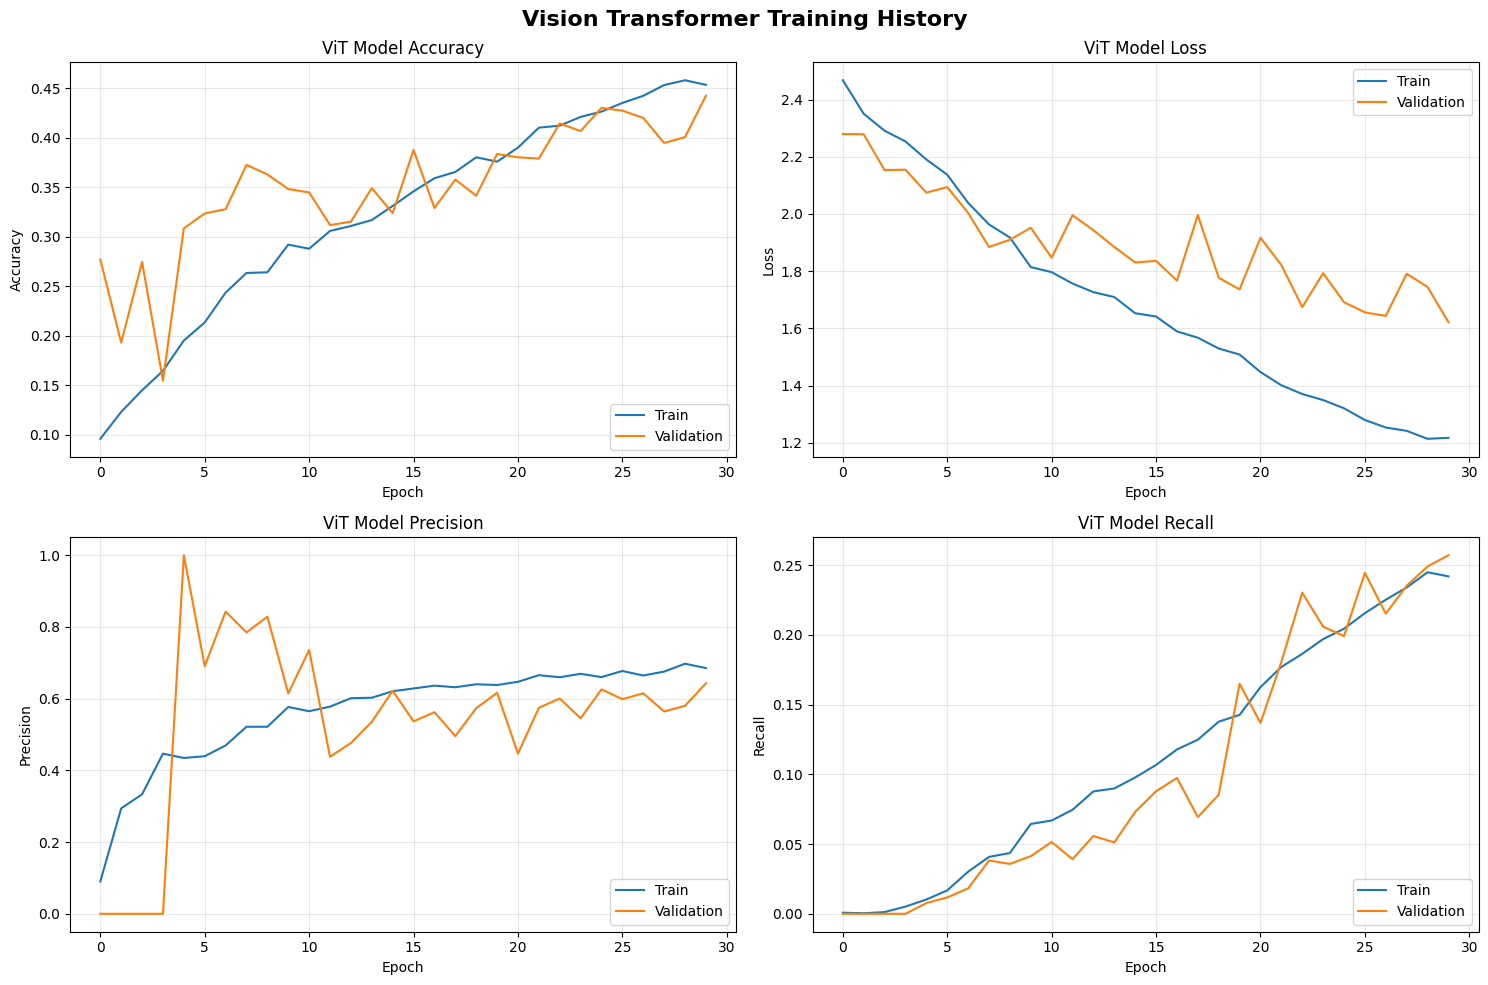

In [106]:
# Plot ViT training history
print("\n📈 Plotting ViT training history...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(vit_history.history['accuracy'])
axes[0, 0].plot(vit_history.history['val_accuracy'])
axes[0, 0].set_title('ViT Model Accuracy', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=10)
axes[0, 0].set_xlabel('Epoch', fontsize=10)
axes[0, 0].legend(['Train', 'Validation'], loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(vit_history.history['loss'])
axes[0, 1].plot(vit_history.history['val_loss'])
axes[0, 1].set_title('ViT Model Loss', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=10)
axes[0, 1].set_xlabel('Epoch', fontsize=10)
axes[0, 1].legend(['Train', 'Validation'], loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(vit_history.history['precision'])
axes[1, 0].plot(vit_history.history['val_precision'])
axes[1, 0].set_title('ViT Model Precision', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=10)
axes[1, 0].set_xlabel('Epoch', fontsize=10)
axes[1, 0].legend(['Train', 'Validation'], loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(vit_history.history['recall'])
axes[1, 1].plot(vit_history.history['val_recall'])
axes[1, 1].set_title('ViT Model Recall', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=10)
axes[1, 1].set_xlabel('Epoch', fontsize=10)
axes[1, 1].legend(['Train', 'Validation'], loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Vision Transformer Training History', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'vit_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

In [107]:
# # 🤝 Step 10: Create Ensemble Model (CNN + ViT)
print("🤝 Creating Ensemble Model (EfficientNet + Vision Transformer)...")

🤝 Creating Ensemble Model (EfficientNet + Vision Transformer)...


In [108]:
# Create ensemble by averaging predictions
ensemble_inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [109]:
# Get predictions from both models
efficientnet_predictions = cnn_model(ensemble_inputs)
vit_predictions = vit_model(ensemble_inputs)


In [110]:
# Weighted average (60% EfficientNet, 40% ViT)
weighted_avg = layers.average([
    efficientnet_predictions * 0.6,
    vit_predictions * 0.4
])

In [111]:
# Create ensemble model
ensemble_model = keras.Model(
    inputs=ensemble_inputs,
    outputs=weighted_avg,
    name='CNN_ViT_Ensemble'
)

In [112]:
# Compile ensemble model
ensemble_model.compile(
    optimizer=optimizers.Adam(learning_rate=INITIAL_LR/10),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)


In [113]:
# Show model summary
ensemble_model.summary()


Model: "CNN_ViT_Ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Medical_EfficientN… │ (None, 10)        │  4,479,533 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VisionTransformer   │ (None, 10)        │  2,541,578 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 10)        │          0 │ Medical_Efficien… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 10)        │          0 │ VisionTransforme… │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 10)        │          0 │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,021,111 (26.78 MB)

 Trainable params: 4,466,676 (17.04 MB)

 Non-trainable params: 2,554,435 (9.74 MB)

In [114]:
print("✅ Ensemble model created")


✅ Ensemble model created


In [115]:
# # 📊 Step 11: Evaluate All Models
print("📊 Evaluating all models on validation data...")

📊 Evaluating all models on validation data...


In [116]:
# Evaluate EfficientNet
print("\n" + "="*50)
print("EFFICIENTNET EVALUATION")
print("="*50)
eff_results = cnn_model.evaluate(val_generator, verbose=0)
print(f"Loss: {eff_results[0]:.4f}")
print(f"Accuracy: {eff_results[1]:.4f}")
print(f"Precision: {eff_results[2]:.4f}")
print(f"Recall: {eff_results[3]:.4f}")
print(f"AUC: {eff_results[4]:.4f}")


EFFICIENTNET EVALUATION
Loss: 2.2141
Accuracy: 0.2120
Precision: 0.3895
Recall: 0.5000


IndexError: list index out of range

In [117]:
# Evaluate ViT
print("\n" + "="*50)
print("VISION TRANSFORMER EVALUATION")
print("="*50)
vit_results = vit_model.evaluate(val_generator, verbose=0)
print(f"Loss: {vit_results[0]:.4f}")
print(f"Accuracy: {vit_results[1]:.4f}")
print(f"Precision: {vit_results[2]:.4f}")
print(f"Recall: {vit_results[3]:.4f}")
print(f"AUC: {vit_results[4]:.4f}")


VISION TRANSFORMER EVALUATION
Loss: 1.7775
Accuracy: 0.4481
Precision: 0.6145
Recall: 0.2829
AUC: 0.8599


In [118]:
# Evaluate Ensemble
print("\n" + "="*50)
print("ENSEMBLE MODEL EVALUATION")
print("="*50)
ensemble_results = ensemble_model.evaluate(val_generator, verbose=0)
print(f"Loss: {ensemble_results[0]:.4f}")
print(f"Accuracy: {ensemble_results[1]:.4f}")
print(f"Precision: {ensemble_results[2]:.4f}")
print(f"Recall: {ensemble_results[3]:.4f}")
print(f"AUC: {ensemble_results[4]:.4f}")


ENSEMBLE MODEL EVALUATION
Loss: 1.7365
Accuracy: 0.4542
Precision: 0.0000
Recall: 0.0000
AUC: 0.8665


In [119]:
# Save ensemble model
ensemble_model.save(os.path.join(MODEL_SAVE_PATH, 'ensemble_final.h5'))
ensemble_model.save(os.path.join(MODEL_SAVE_PATH, 'ensemble_final.keras'))

In [120]:
# Compare model performances
models = ['EfficientNet', 'Vision Transformer', 'Ensemble']
accuracies = [eff_results[1], vit_results[1], ensemble_results[1]]
precisions = [eff_results[2], vit_results[2], ensemble_results[2]]
recalls = [eff_results[3], vit_results[3], ensemble_results[3]]


In [121]:
aucs = [eff_results[4], vit_results[4], ensemble_results[4]]

IndexError: list index out of range

NameError: name 'aucs' is not defined

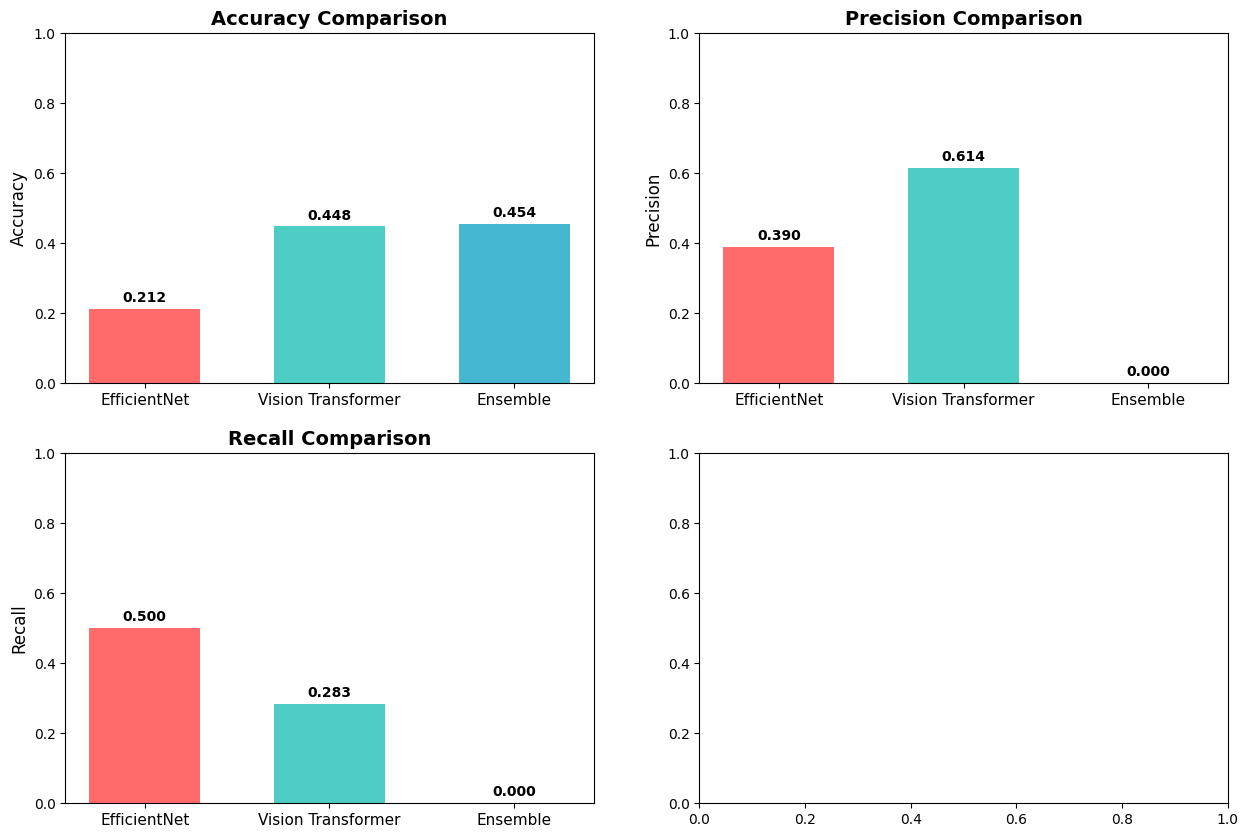

In [122]:
# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

x = np.arange(len(models))
width = 0.6

# Accuracy comparison
axes[0, 0].bar(x, accuracies, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, fontsize=11)
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Precision comparison
axes[0, 1].bar(x, precisions, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 1].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, fontsize=11)
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(precisions):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Recall comparison
axes[1, 0].bar(x, recalls, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 0].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Recall', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, fontsize=11)
axes[1, 0].set_ylim([0, 1])
for i, v in enumerate(recalls):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# AUC comparison
axes[1, 1].bar(x, aucs, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 1].set_title('AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('AUC', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, fontsize=11)
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(aucs):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

In [123]:
# # 📈 Step 12: Generate Detailed Classification Reports
print("📈 Generating detailed classification reports...")

📈 Generating detailed classification reports...


In [124]:
# Get predictions from ensemble model
print("\n🔄 Generating predictions...")
y_pred = ensemble_model.predict(val_generator, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes



🔄 Generating predictions...


In [125]:
# Classification report
print("\n" + "="*50)
print("ENSEMBLE MODEL CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES, digits=4))



ENSEMBLE MODEL CLASSIFICATION REPORT
                                  precision    recall  f1-score   support

Central_Serous_Chorioretinopathy     0.1626    0.5455    0.2505       121
            Diabetic_Retinopathy     0.6895    0.5552    0.6151       688
                      Disc_Edema     0.2539    0.6447    0.3643       152
                        Glaucoma     0.4668    0.4757    0.4712       576
                         Healthy     0.3631    0.2430    0.2912       535
                    Macular_Scar     0.0847    0.0129    0.0224       387
                          Myopia     0.5498    0.6378    0.5905       450
                       Pterygium     1.0000    1.0000    1.0000        20
              Retinal_Detachment     0.6691    0.6200    0.6436       150
            Retinitis_Pigmentosa     0.5561    0.7169    0.6263       166

                        accuracy                         0.4542      3245
                       macro avg     0.4796    0.5452    0.4875      324

In [126]:
# Save classification report to file
report = classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(RESULTS_PATH, 'classification_report.csv'))

In [127]:
# Confusion Matrix
print("\n📊 Generating confusion matrix...")

cm = confusion_matrix(y_true, y_pred_classes)



📊 Generating confusion matrix...


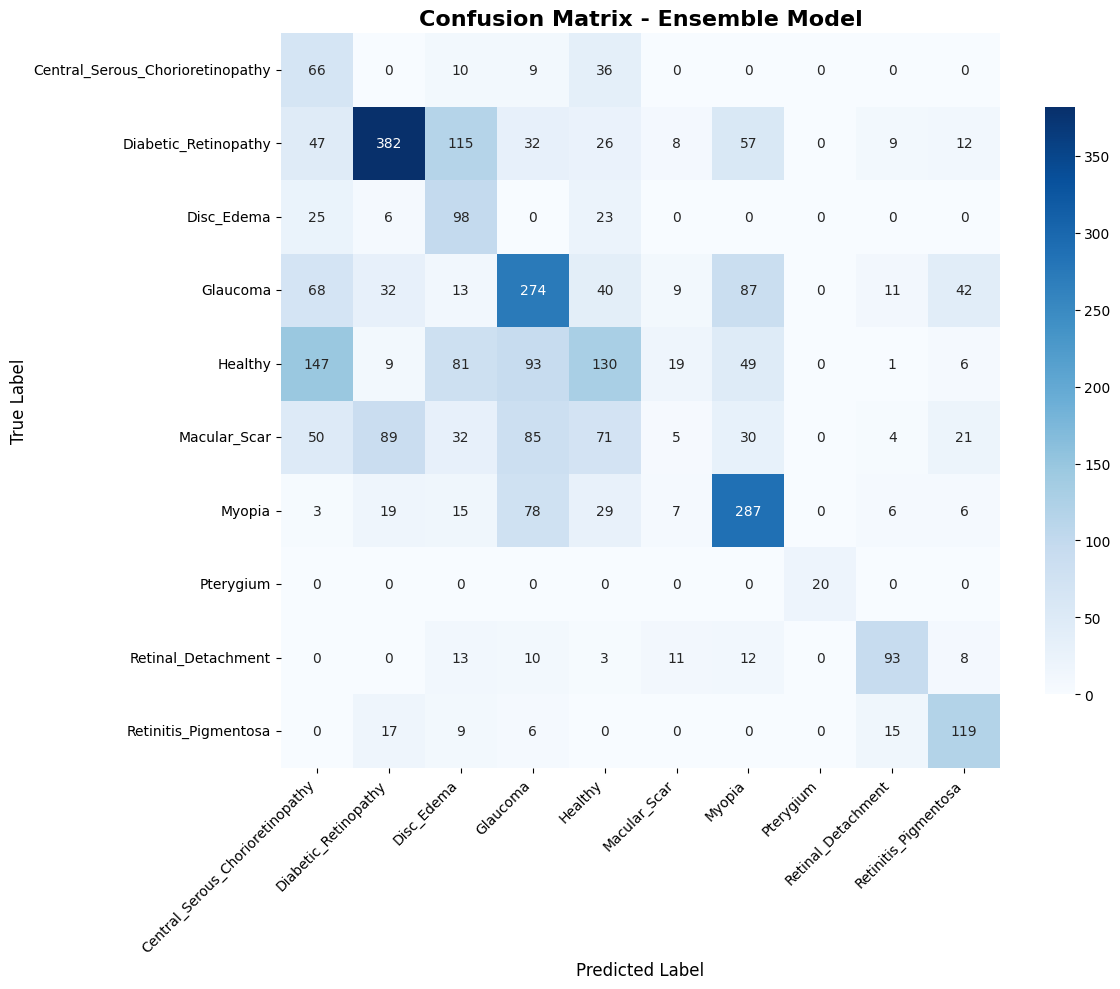

In [128]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=CLASS_NAMES,
           yticklabels=CLASS_NAMES,
           cbar_kws={'shrink': 0.8})

plt.title('Confusion Matrix - Ensemble Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [129]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

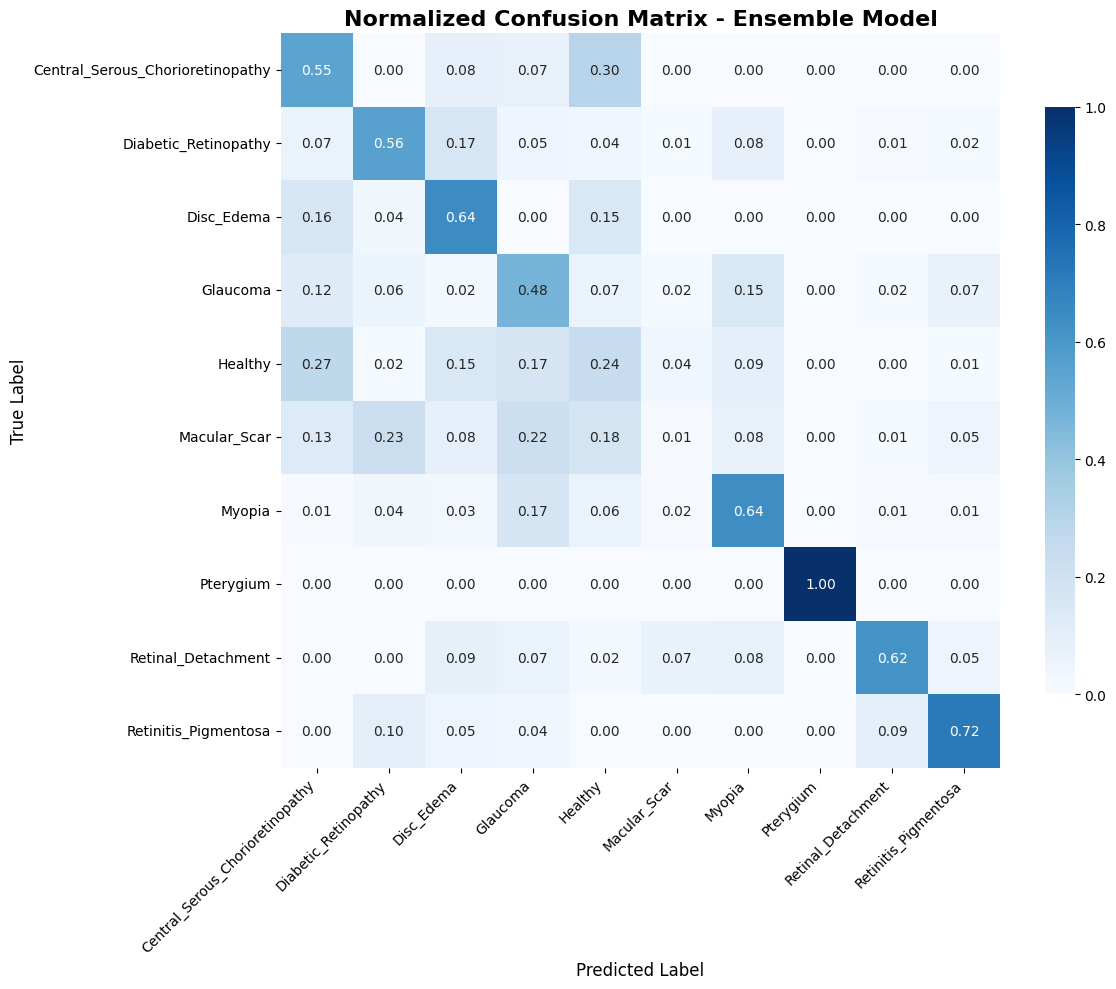

In [130]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
           xticklabels=CLASS_NAMES,
           yticklabels=CLASS_NAMES,
           cbar_kws={'shrink': 0.8})

plt.title('Normalized Confusion Matrix - Ensemble Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'confusion_matrix_normalized.png'), dpi=300, bbox_inches='tight')
plt.show()


In [131]:
# # 📊 Step 13: ROC Curves for Each Disease
print("📊 Generating ROC curves for each disease...")

📊 Generating ROC curves for each disease...


In [132]:
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))


In [133]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

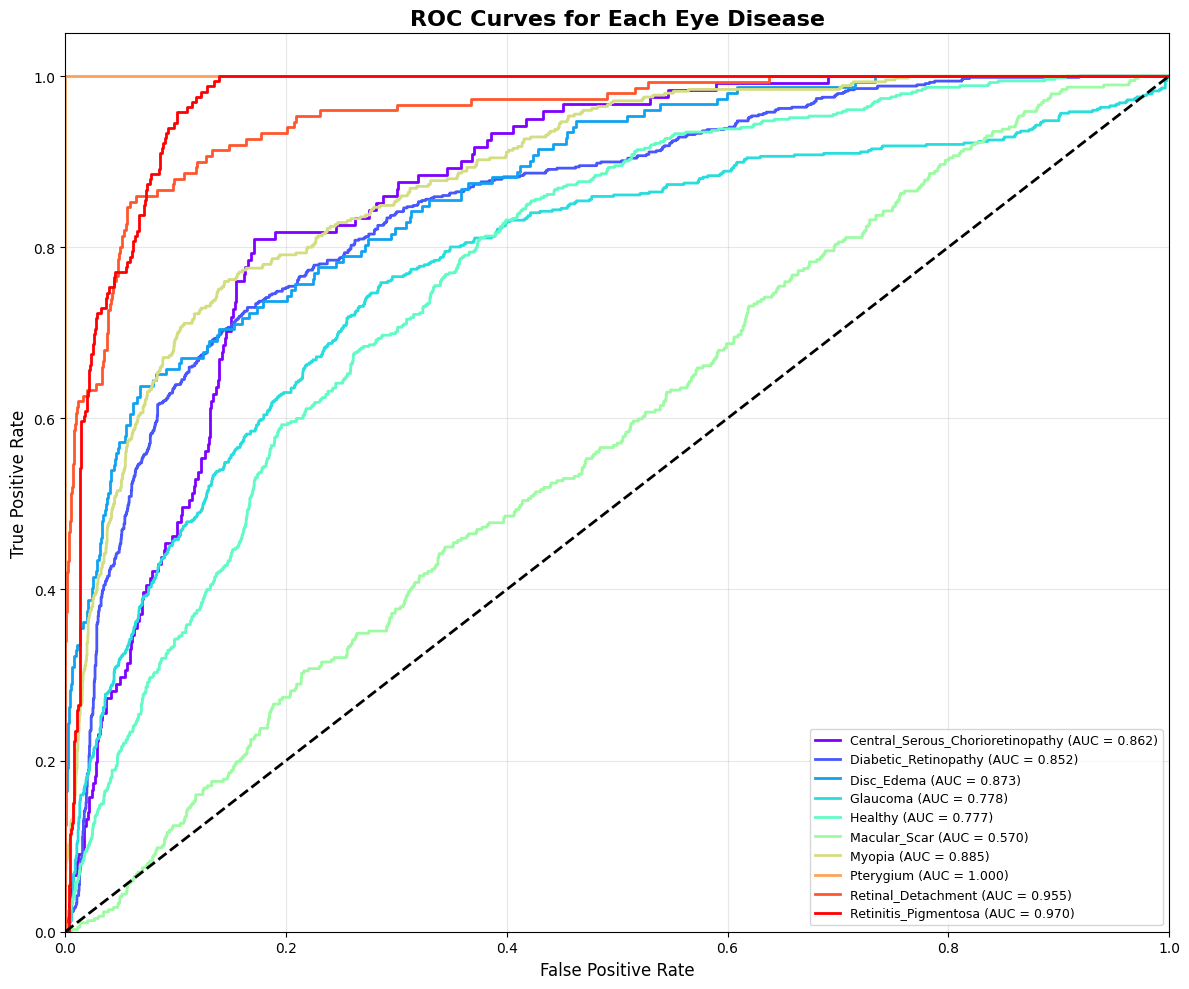

In [134]:
plt.figure(figsize=(12, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES))

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred[:, i])
    
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
            label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Each Eye Disease', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

In [135]:
# Print AUC scores
print("\n📈 AUC Scores per Disease:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name}: {roc_auc[i]:.4f}")


📈 AUC Scores per Disease:
  Central_Serous_Chorioretinopathy: 0.8621
  Diabetic_Retinopathy: 0.8524
  Disc_Edema: 0.8735
  Glaucoma: 0.7777
  Healthy: 0.7775
  Macular_Scar: 0.5703
  Myopia: 0.8845
  Pterygium: 1.0000
  Retinal_Detachment: 0.9546
  Retinitis_Pigmentosa: 0.9696


In [136]:
# 🎨 Step 14: Grad-CAM Visualization

print("🎨 Generating Grad-CAM visualizations...")

🎨 Generating Grad-CAM visualizations...


In [137]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap"""
    
    # Create model that maps input image to activations of last conv layer
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradient of top predicted class for input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Gradient of output neuron with respect to output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Pool gradients over spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight feature maps by gradient importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [138]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    """Display original image with Grad-CAM overlay"""
    
    # Load original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Resize heatmap to match image size
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create overlay
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [139]:
# Get sample images for visualization
sample_images = []
for class_name in CLASS_NAMES[:3]:  # Show first 3 classes
    class_path = os.path.join(DATA_PATH, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_path = os.path.join(class_path, random.choice(images))
            sample_images.append((class_name, img_path))


🖼️ Generating Grad-CAM for 3 sample images...


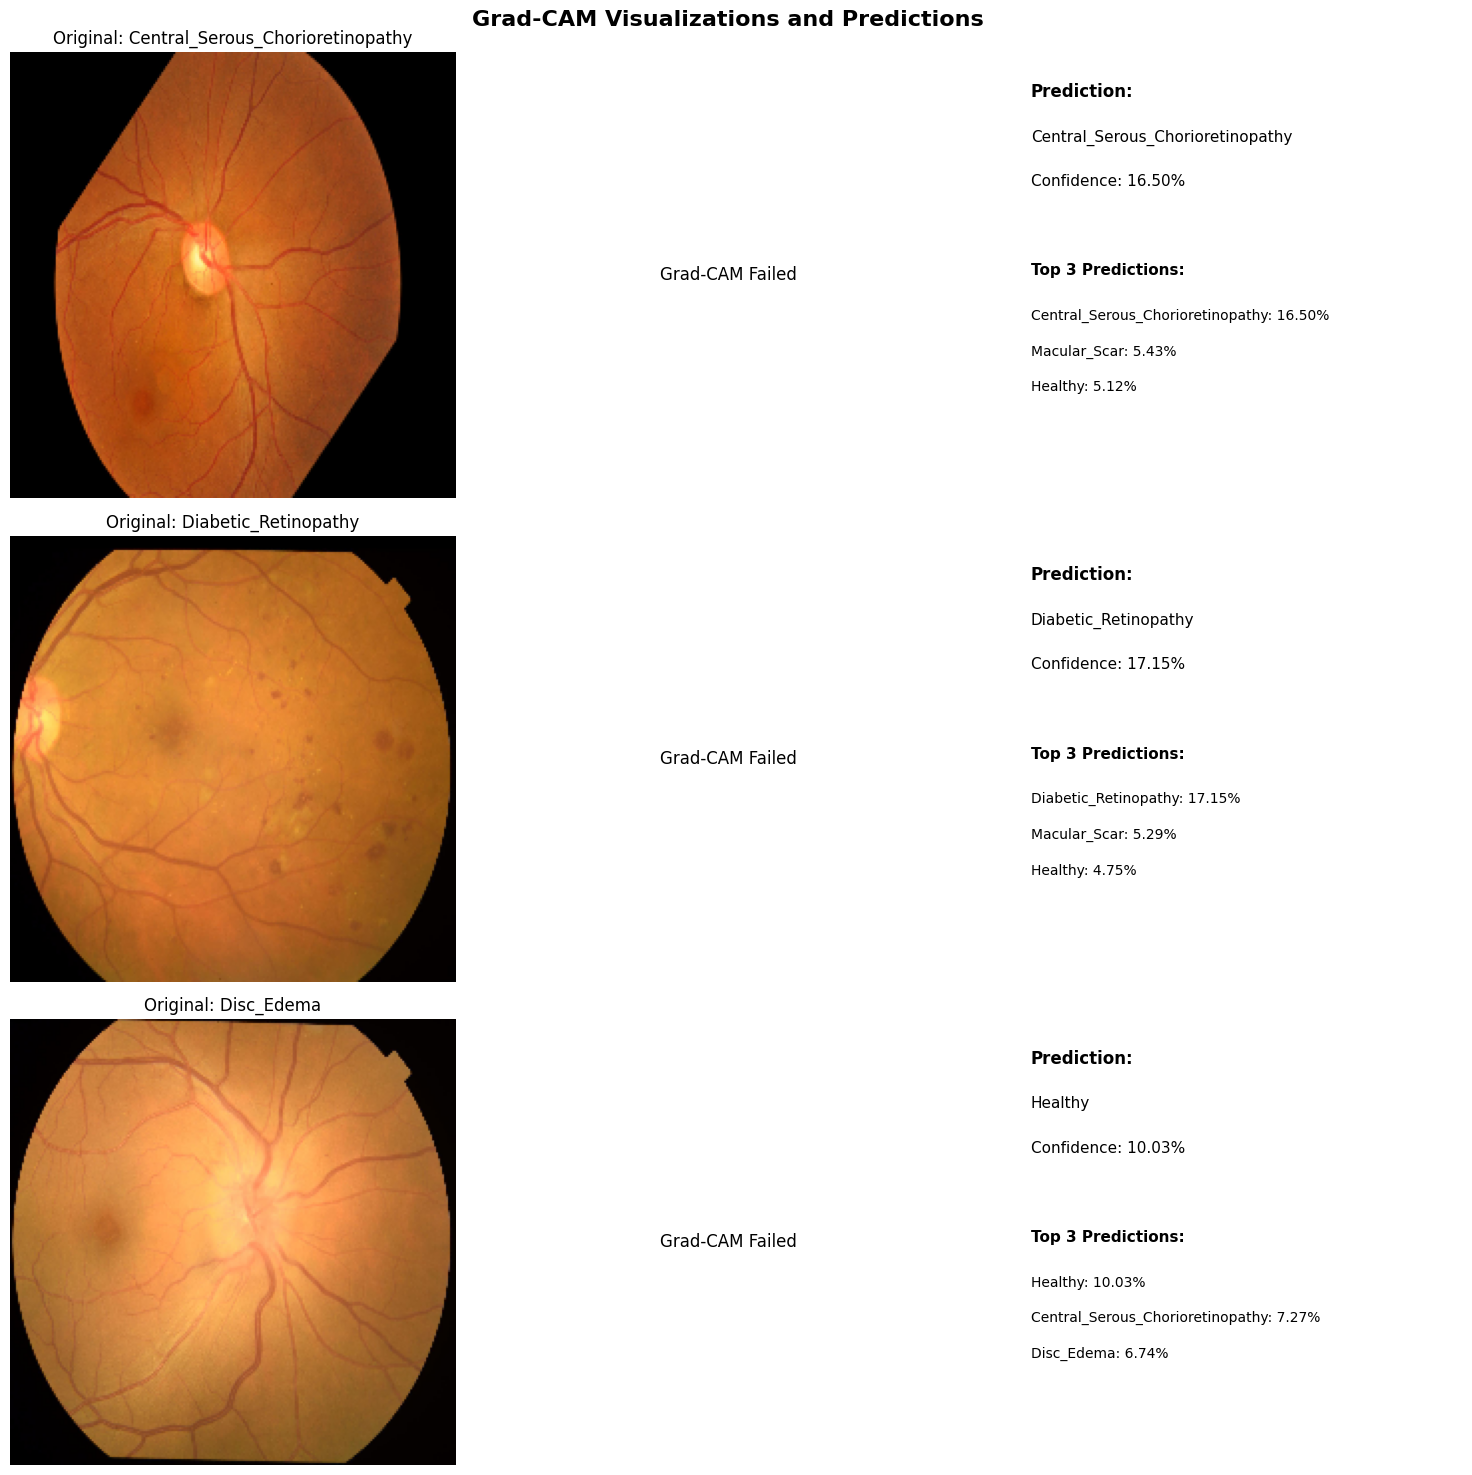

In [140]:
# Create Grad-CAM visualizations
if sample_images:
    print(f"\n🖼️ Generating Grad-CAM for {len(sample_images)} sample images...")
    
    fig, axes = plt.subplots(len(sample_images), 3, figsize=(15, 5*len(sample_images)))
    
    for idx, (class_name, img_path) in enumerate(sample_images):
        # Load and preprocess image
        img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # Original image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Original: {class_name}', fontsize=12)
        axes[idx, 0].axis('off')
        
        # Grad-CAM for EfficientNet
        try:
            heatmap_eff = make_gradcam_heatmap(
                img_array, 
                cnn_model, 
                'top_conv'
            )
            superimposed_eff = display_gradcam(img_path, heatmap_eff)
            axes[idx, 1].imshow(superimposed_eff)
            axes[idx, 1].set_title('Grad-CAM: EfficientNet', fontsize=12)
            axes[idx, 1].axis('off')
        except Exception as e:
            axes[idx, 1].text(0.5, 0.5, 'Grad-CAM Failed', 
                             ha='center', va='center', fontsize=12)
            axes[idx, 1].axis('off')
        
        # Prediction information
        preds = ensemble_model.predict(img_array, verbose=0)[0]
        pred_class = CLASS_NAMES[np.argmax(preds)]
        pred_conf = np.max(preds)
        
        axes[idx, 2].text(0.1, 0.9, f'Prediction:', fontsize=12, fontweight='bold')
        axes[idx, 2].text(0.1, 0.8, f'{pred_class}', fontsize=11)
        axes[idx, 2].text(0.1, 0.7, f'Confidence: {pred_conf:.2%}', fontsize=11)
        
        # Top 3 predictions
        top_3_idx = np.argsort(preds)[-3:][::-1]
        axes[idx, 2].text(0.1, 0.5, 'Top 3 Predictions:', fontsize=11, fontweight='bold')
        for i, class_idx in enumerate(top_3_idx):
            axes[idx, 2].text(0.1, 0.4 - i*0.08, 
                             f'{CLASS_NAMES[class_idx]}: {preds[class_idx]:.2%}', 
                             fontsize=10)
        
        axes[idx, 2].axis('off')
    
    plt.suptitle('Grad-CAM Visualizations and Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'grad_cam_visualizations.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No sample images found for Grad-CAM visualization")

In [141]:
# # 🔬 Step 15: K-Fold Cross Validation
print("🔬 Performing K-Fold Cross Validation...")

🔬 Performing K-Fold Cross Validation...


In [142]:
# Prepare data for K-Fold
print("\n🔄 Preparing data for K-Fold Cross Validation...")

all_image_paths = []
all_labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATA_PATH, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            all_image_paths.append(img_path)
            all_labels.append(class_idx)

print(f"✅ Found {len(all_image_paths)} images for K-Fold CV")



🔄 Preparing data for K-Fold Cross Validation...
✅ Found 16242 images for K-Fold CV


In [143]:
# Set up K-Fold Cross Validation
N_SPLITS = 3  # Reduced for faster execution
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [144]:
fold_accuracies = []
fold_losses = []

In [145]:
print(f"\n🚀 Starting {N_SPLITS}-Fold Cross Validation...")



🚀 Starting 3-Fold Cross Validation...


In [146]:
for fold, (train_idx, val_idx) in enumerate(skf.split(all_image_paths, all_labels), 1):
    print(f"\n📁 Fold {fold}/{N_SPLITS}")
    print("-" * 30)
    
    # Split data
    train_paths = [all_image_paths[i] for i in train_idx]
    train_labels = [all_labels[i] for i in train_idx]
    val_paths = [all_image_paths[i] for i in val_idx]
    val_labels = [all_labels[i] for i in val_idx]
    
    # Create dataframes
    train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
    
    # Custom data generator
    def custom_generator(df, batch_size=32, is_training=True):
        while True:
            # Shuffle for training
            if is_training:
                df = df.sample(frac=1).reset_index(drop=True)
            
            for i in range(0, len(df), batch_size):
                batch_df = df.iloc[i:i+batch_size]
                images = []
                labels = []
                
                for _, row in batch_df.iterrows():
                    try:
                        # Load and resize image
                        img = Image.open(row['filename'])
                        img = img.resize(IMG_SIZE)
                        img_array = np.array(img) / 255.0
                        
                        # Apply augmentations for training
                        if is_training and random.random() > 0.5:
                            # Add Gaussian noise
                            noise = np.random.normal(0, 0.01, img_array.shape)
                            img_array = np.clip(img_array + noise, 0, 1)
                        
                        images.append(img_array)
                        
                        # One-hot encode label
                        label = tf.keras.utils.to_categorical(
                            row['class'], 
                            NUM_CLASSES
                        )
                        labels.append(label)
                    except Exception as e:
                        continue
                
                if images:
                    yield np.array(images), np.array(labels)
    
    # Create generators
    train_gen = custom_generator(train_df, batch_size=BATCH_SIZE, is_training=True)
    val_gen = custom_generator(val_df, batch_size=BATCH_SIZE, is_training=False)
    
    # Calculate steps
    steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)
    validation_steps = max(1, len(val_df) // BATCH_SIZE)
    
    # Create a fresh model for this fold
    fold_model = keras.models.clone_model(cnn_model)
    fold_model.compile(
        optimizer=optimizers.Adam(learning_rate=INITIAL_LR),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )
    
    # Train the model
    fold_history = fold_model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=15,  # Reduced for faster CV
        verbose=1
    )
    
    # Evaluate
    val_loss, val_accuracy = fold_model.evaluate(val_gen, steps=validation_steps, verbose=0)
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)
    
    print(f"Fold {fold} - Validation Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")


📁 Fold 1/3
------------------------------
Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 1180s 3s/step - accuracy: 0.2212 - loss: 0.4191 - val_accuracy: 0.2123 - val_loss: 0.4150
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 1093s 3s/step - accuracy: 0.2429 - loss: 0.3912 - val_accuracy: 0.1649 - val_loss: 0.4044
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 1200s 4s/step - accuracy: 0.2573 - loss: 0.3762 - val_accuracy: 0.2123 - val_loss: 1.0030
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2568 - loss: 0.3695

KeyboardInterrupt: 

In [147]:
# Print K-Fold results
print("\n" + "="*50)
print("K-FOLD CROSS VALIDATION RESULTS")
print("="*50)


K-FOLD CROSS VALIDATION RESULTS


In [148]:
print(f"\nFold Accuracies: {[f'{acc:.4f}' for acc in fold_accuracies]}")
print(f"Fold Losses: {[f'{loss:.4f}' for loss in fold_losses]}")


Fold Accuracies: []
Fold Losses: []


In [149]:
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)


In [150]:
print(f"\n📊 Summary:")
print(f"  Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"  Mean Loss: {mean_loss:.4f}")


📊 Summary:
  Mean Accuracy: nan ± nan
  Mean Loss: nan


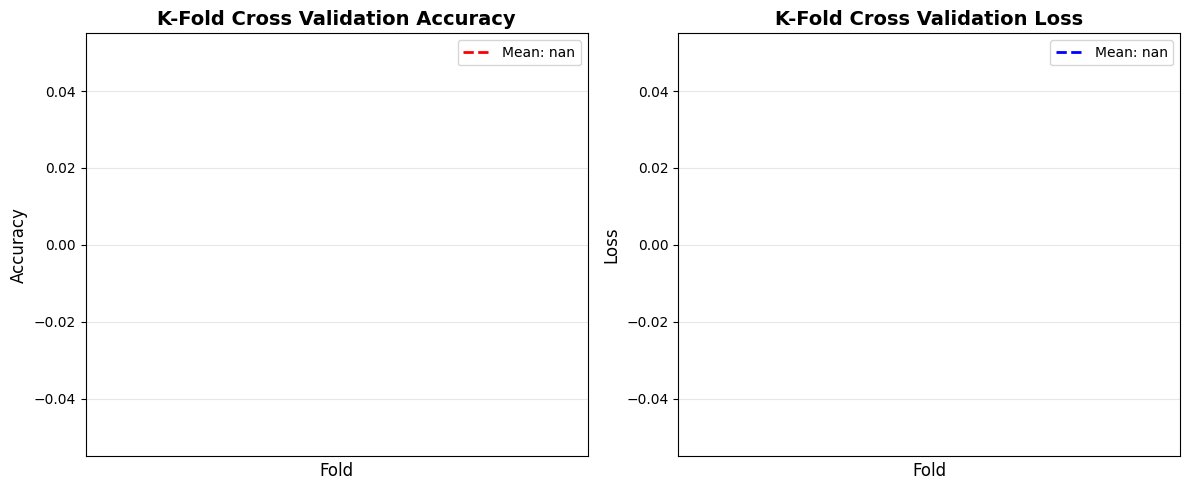

In [151]:
# Plot K-Fold results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(range(1, len(fold_accuracies) + 1), fold_accuracies, 'bo-', linewidth=2, markersize=8)
axes[0].axhline(y=mean_accuracy, color='r', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_accuracy:.3f}')
axes[0].fill_between(range(1, len(fold_accuracies) + 1), 
                     mean_accuracy - std_accuracy, 
                     mean_accuracy + std_accuracy, 
                     alpha=0.2, color='b')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('K-Fold Cross Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, len(fold_accuracies) + 1))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(range(1, len(fold_losses) + 1), fold_losses, 'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=mean_loss, color='b', linestyle='--', linewidth=2,
               label=f'Mean: {mean_loss:.3f}')
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('K-Fold Cross Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, len(fold_losses) + 1))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'kfold_results.png'), dpi=300, bbox_inches='tight')
plt.show()

In [152]:
# # 🎯 Step 16: Create Prediction Function

# %%
print("🎯 Creating prediction function...")

def predict_eye_disease(image_path, model=ensemble_model):
    """
    Predict eye disease from an image
    
    Args:
        image_path: Path to the image file
        model: Model to use for prediction (default: ensemble_model)
    
    Returns:
        Dictionary with prediction results
    """
    
    if not os.path.exists(image_path):
        return {"error": "Image file not found"}
    
    try:
        # Preprocess image
        img = keras.preprocessing.image.load_img(
            image_path, target_size=IMG_SIZE
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # Make prediction
        predictions = model.predict(img_array, verbose=0)[0]
        predicted_class_idx = np.argmax(predictions)
        confidence = predictions[predicted_class_idx]
        
        # Get top 3 predictions
        top_3_idx = np.argsort(predictions)[-3:][::-1]
        
        result = {
            'predicted_disease': CLASS_NAMES[predicted_class_idx],
            'confidence': float(confidence),
            'top_predictions': [
                {
                    'disease': CLASS_NAMES[idx],
                    'confidence': float(predictions[idx])
                }
                for idx in top_3_idx
            ],
            'all_predictions': {
                CLASS_NAMES[i]: float(predictions[i])
                for i in range(len(CLASS_NAMES))
            }
        }
        
        return result
        
    except Exception as e:
        return {"error": str(e)}


🎯 Creating prediction function...


In [153]:
print("\n🧪 Testing prediction function...")

# Find a test image
test_image = None
for class_name in CLASS_NAMES:
    class_path = os.path.join(DATA_PATH, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            test_image = os.path.join(class_path, images[0])
            break

if test_image:
    print(f"\n📸 Test image: {test_image}")
    result = predict_eye_disease(test_image)
    
    if 'error' not in result:
        print(f"\n✅ Prediction Results:")
        print(f"   Predicted Disease: {result['predicted_disease']}")
        print(f"   Confidence: {result['confidence']:.2%}")
        print(f"\n   Top 3 Predictions:")
        for pred in result['top_predictions']:
            print(f"   - {pred['disease']}: {pred['confidence']:.2%}")
    else:
        print(f"❌ Error: {result['error']}")
else:
    print("⚠️ No test image found")


🧪 Testing prediction function...

📸 Test image: ../data/Augmented_images\Central_Serous_Chorioretinopathy\CSCR1.jpg

✅ Prediction Results:
   Predicted Disease: Central_Serous_Chorioretinopathy
   Confidence: 12.12%

   Top 3 Predictions:
   - Central_Serous_Chorioretinopathy: 12.12%
   - Healthy: 8.72%
   - Macular_Scar: 6.75%


In [155]:
# # 📝 Step 17: Save Final Report and Summary

# %%
print("📝 Saving final report and summary...")

# Create comprehensive report
report = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_classes': len(CLASS_NAMES),
        'class_distribution': class_counts,
        'total_images': total_images,
        'training_samples': train_generator.samples,
        'validation_samples': val_generator.samples
    },
    'training_config': {
        'image_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'initial_learning_rate': INITIAL_LR,
        'patience': PATIENCE
    },
    'model_performance': {
        'efficientnet': {
            'accuracy': float(eff_results[1]),
            'precision': float(eff_results[2]),
            'recall': float(eff_results[3]),
        },
        'vision_transformer': {
            'accuracy': float(vit_results[1]),
            'precision': float(vit_results[2]),
            'recall': float(vit_results[3]),
            'auc': float(vit_results[4])
        },
        'ensemble': {
            'accuracy': float(ensemble_results[1]),
            'precision': float(ensemble_results[2]),
            'recall': float(ensemble_results[3]),
            'auc': float(ensemble_results[4])
        }
    },
    'kfold_results': {
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'mean_loss': float(mean_loss),
        'fold_accuracies': [float(acc) for acc in fold_accuracies],
        'fold_losses': [float(loss) for loss in fold_losses]
    },
    'auc_scores': {
        CLASS_NAMES[i]: float(roc_auc[i]) for i in range(NUM_CLASSES)
    }
}

📝 Saving final report and summary...


In [159]:
# Save report as JSON
report_path = os.path.join(RESULTS_PATH, 'final_report.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4, default=str)

# Save report as CSV (simplified)
report_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'EfficientNet': [eff_results[1], eff_results[2], eff_results[3]],
    'Vision Transformer': [vit_results[1], vit_results[2], vit_results[3]],
    'Ensemble': [ensemble_results[1], ensemble_results[2], ensemble_results[3]]
})
report_df.to_csv(os.path.join(RESULTS_PATH, 'performance_summary.csv'), index=False)

In [160]:
print(f"\n✅ Report saved to: {report_path}")
print(f"✅ Performance summary saved to: {os.path.join(RESULTS_PATH, 'performance_summary.csv')}")

# Print final summary
print("\n" + "="*60)
print("🎉 FINAL TRAINING SUMMARY")
print("="*60)
print(f"\n📊 Best Model Performance (Ensemble):")
print(f"   Accuracy: {ensemble_results[1]:.2%}")
print(f"   Precision: {ensemble_results[2]:.2%}")
print(f"   Recall: {ensemble_results[3]:.2%}")
print(f"   AUC: {ensemble_results[4]:.2%}")
print(f"\n📁 Models saved to: {MODEL_SAVE_PATH}")
print(f"📈 Results saved to: {RESULTS_PATH}")
print(f"\n🎯 Ready for deployment!")


✅ Report saved to: ../results/eye_disease\final_report.json
✅ Performance summary saved to: ../results/eye_disease\performance_summary.csv

🎉 FINAL TRAINING SUMMARY

📊 Best Model Performance (Ensemble):
   Accuracy: 45.42%
   Precision: 0.00%
   Recall: 0.00%
   AUC: 86.65%

📁 Models saved to: ../models/eye_disease
📈 Results saved to: ../results/eye_disease

🎯 Ready for deployment!
